<a href="https://colab.research.google.com/github/JerryX1110/insolitum/blob/main/notebooks/Interacting_with_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 2.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yqt7mx63
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yqt7mx63
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=dc17cc57a9164fff1ff49d9c6e16bd5f2d74011ca77cde713431bffc1bb007a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-337i0u7f/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.13.1+cu116


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [15]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [16]:
model, preprocess = clip.load("ViT-L/14")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 890M/890M [00:04<00:00, 203MiB/s]


Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [17]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa19d7eab80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [18]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [3]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

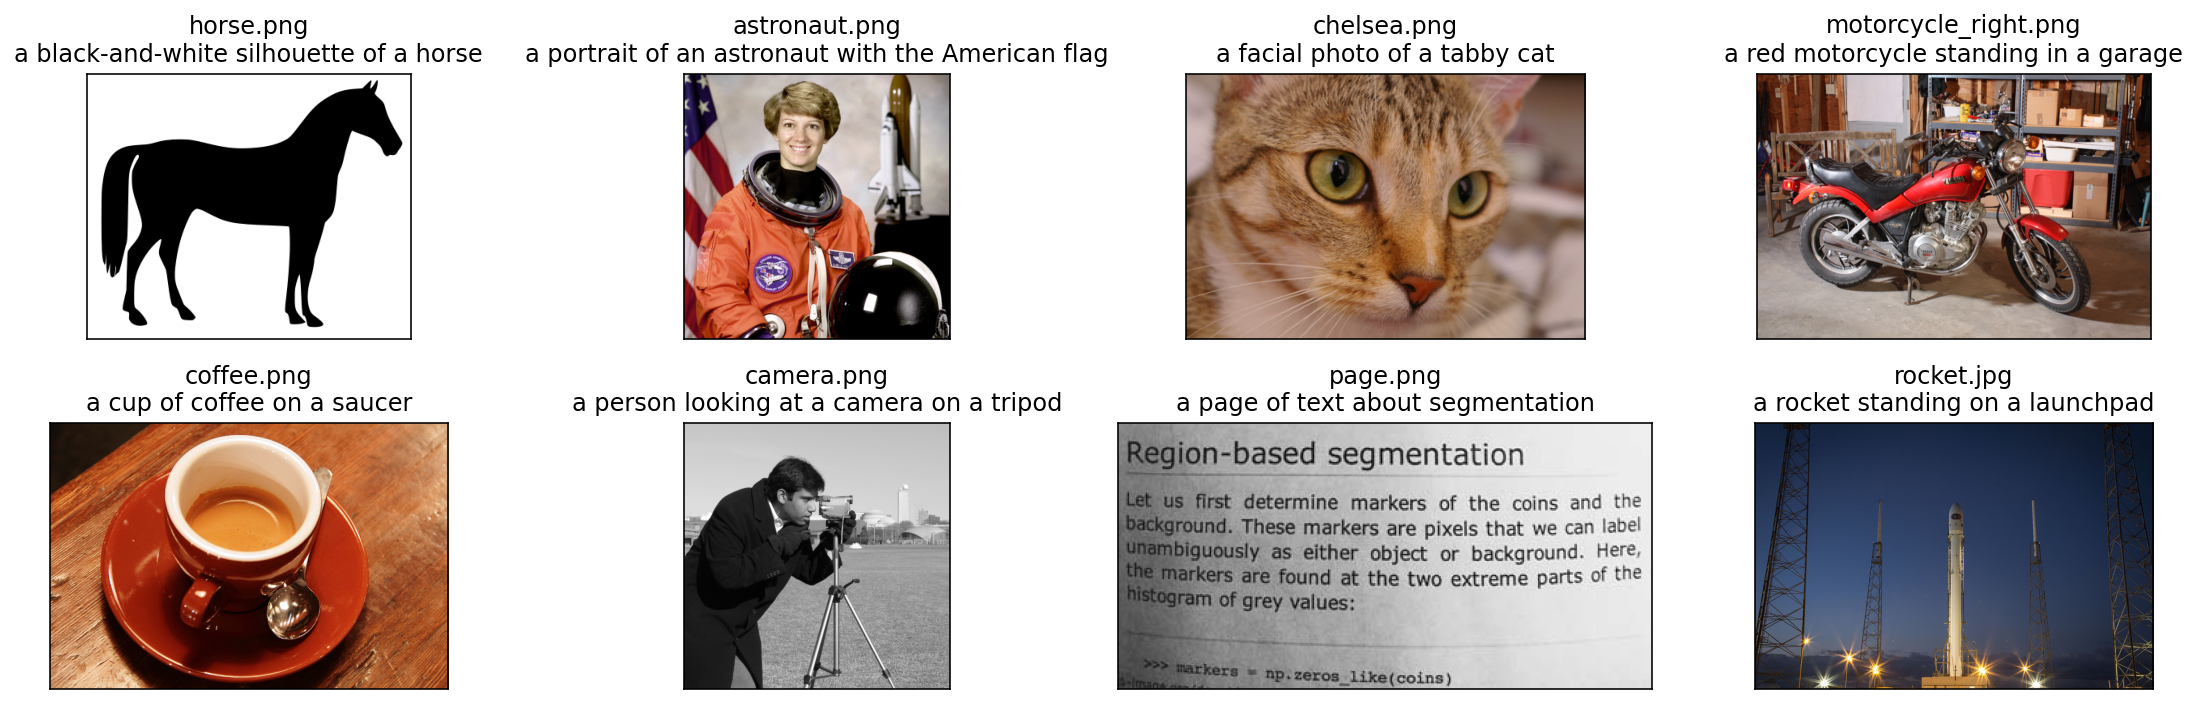

In [20]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


In [27]:
!ls


000.png  007.png  015.png  sample_data


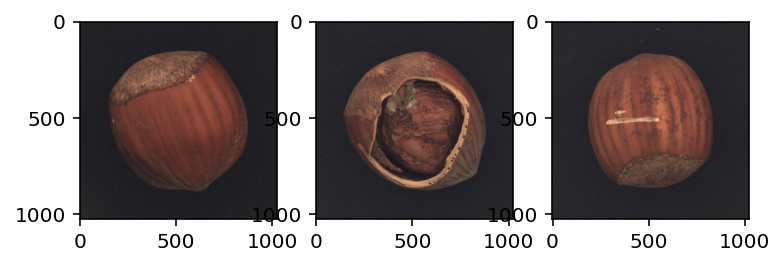

In [6]:
image = Image.open("000.png").convert("RGB")
plt.subplot(1, 3, 1)
plt.imshow(image)
image = Image.open("007.png").convert("RGB")
plt.subplot(1, 3, 2)
plt.imshow(image)
image = Image.open("015.png").convert("RGB")
plt.subplot(1, 3, 3)
plt.imshow(image)

# RN50x64

### 000.png
Label normal probs: 0.1586
Label abnormal probs: 0.0823
Label good probs: 0.03223
Label bad probs: 0.2135
Label broken probs: 0.512
Label with scratch probs: 0.001394
### 000.png
Label normal hazelnut probs: 0.2015
Label abnormal hazelnut probs: 0.4072
Label good hazelnut probs: 0.03787
Label bad hazelnut probs: 0.03613
Label broken hazelnut probs: 0.2932
Label hazelnut with scratch probs: 0.02408


'Done'

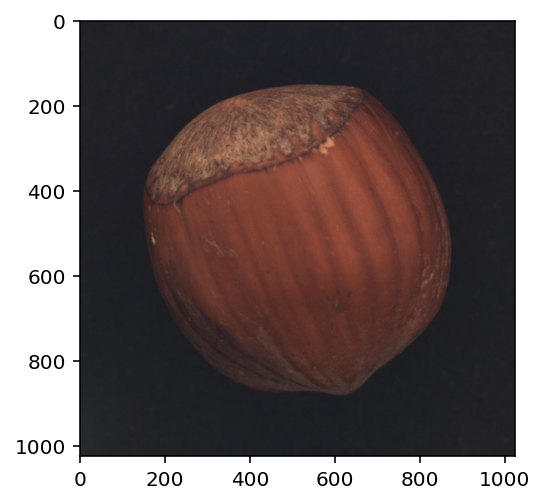

In [49]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

def get_clip_prob(img_name,attribute_list, vis=True):
  print("###", img_name)
  if vis == True:
    image = Image.open(img_name).convert("RGB")
    plt.imshow(image)
    #plt.close()
  image = preprocess(Image.open(img_name)).unsqueeze(0).to(device)
  text = clip.tokenize(attribute_list).to(device)
  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
  for idx, i in enumerate(attribute_list):
    print("Label "+str(i)+" probs:", probs[0][idx])  
  return "Done"


img_name = "000.png"
attribute_list = ["normal", "abnormal", "good", "bad", "broken", "with scratch"]
get_clip_prob(img_name,attribute_list)
attribute_list = ["normal hazelnut", "abnormal hazelnut", "good hazelnut", "bad hazelnut", "broken hazelnut", "hazelnut with scratch"]
get_clip_prob(img_name,attribute_list)

100%|█████████████████████████████████████| 1.26G/1.26G [00:33<00:00, 40.0MiB/s]


### 000.png
Label normal probs: 0.439
Label abnormal probs: 0.1328
Label good probs: 0.0318
Label bad probs: 0.06573
Label broken probs: 0.1692
Label with scratch probs: 0.1615
### 000.png
Label normal hazelnut probs: 0.0996
Label abnormal hazelnut probs: 0.861
Label good hazelnut probs: 0.000531
Label bad hazelnut probs: 0.006996
Label broken hazelnut probs: 0.007683
Label hazelnut with scratch probs: 0.02441


'Done'

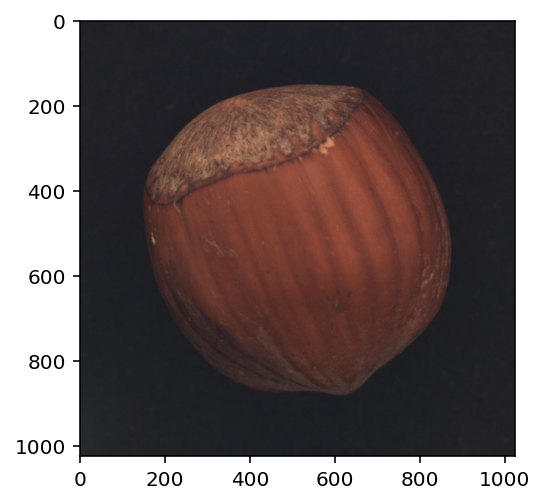

In [50]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50x64", device=device)

def get_clip_prob(img_name,attribute_list, vis=True):
  print("###", img_name)
  if vis == True:
    image = Image.open(img_name).convert("RGB")
    plt.imshow(image)
    #plt.close()
  image = preprocess(Image.open(img_name)).unsqueeze(0).to(device)
  text = clip.tokenize(attribute_list).to(device)
  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
  for idx, i in enumerate(attribute_list):
    print("Label "+str(i)+" probs:", probs[0][idx])  
  return "Done"


img_name = "000.png"
attribute_list = ["normal", "abnormal", "good", "bad", "broken", "with scratch"]
get_clip_prob(img_name,attribute_list)
attribute_list = ["normal hazelnut", "abnormal hazelnut", "good hazelnut", "bad hazelnut", "broken hazelnut", "hazelnut with scratch"]
get_clip_prob(img_name,attribute_list)

### ./good/000.png
normal:  0.1986
abnormal:  0.0543
good:  0.09235
bad:  0.1925
broken:  0.05344
scratch:  0.4011
crack:  0.00782
### ./good/000.png
normal hazelnut:  0.564
abnormal hazelnut:  0.134
good hazelnut:  0.0071
bad hazelnut:  0.002695
broken hazelnut:  0.04852
hazelnut with scratch:  0.0193
hazelnut with crack:  0.2244


'Done'

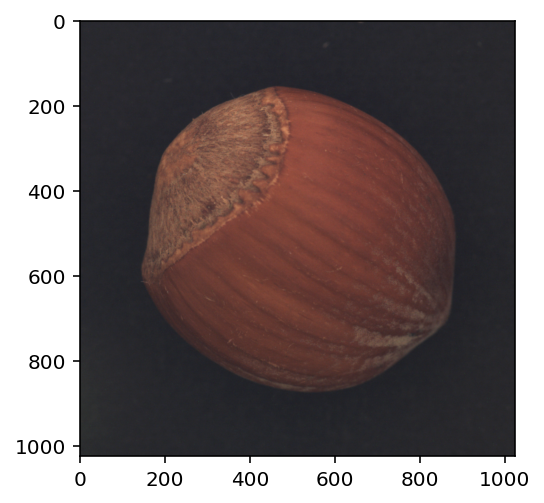

In [82]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def get_clip_prob(img_name,attribute_list, vis=True):
  print("###", img_name)
  if vis == True:
    image = Image.open(img_name).convert("RGB")
    plt.imshow(image)
    #plt.close()
  image = preprocess(Image.open(img_name)).unsqueeze(0).to(device)
  text = clip.tokenize(attribute_list).to(device)
  with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
  for idx, i in enumerate(attribute_list):
    print(str(i)+": " , probs[0][idx])  
  return "Done"


img_name = "./good/000.png"
attribute_list = ["normal", "abnormal", "good", "bad", "broken", "scratch", "crack"]
get_clip_prob(img_name,attribute_list)
attribute_list = ["normal hazelnut", "abnormal hazelnut", "good hazelnut", "bad hazelnut", "broken hazelnut", "hazelnut with scratch", "hazelnut with crack"]
get_clip_prob(img_name,attribute_list)

### ./scratch/007.png
normal:  0.147
abnormal:  0.0402
good:  0.02438
bad:  0.1298
broken:  0.453
scratch:  0.1859
crack:  0.0199
### ./scratch/007.png
normal hazelnut:  0.1893
abnormal hazelnut:  0.04712
good hazelnut:  0.00393
bad hazelnut:  0.002617
broken hazelnut:  0.4136
hazelnut with scratch:  0.03613
hazelnut with crack:  0.3074


'Done'

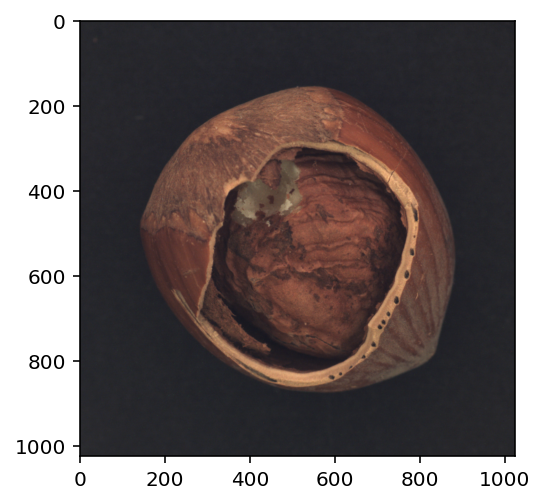

In [83]:
img_name = "./scratch/007.png"
attribute_list = ["normal", "abnormal", "good", "bad", "broken", "scratch", "crack"]
get_clip_prob(img_name,attribute_list)
attribute_list = ["normal hazelnut", "abnormal hazelnut", "good hazelnut", "bad hazelnut", "broken hazelnut", "hazelnut with scratch", "hazelnut with crack"]
get_clip_prob(img_name,attribute_list)

### ./good/015.png
normal:  0.2742
abnormal:  0.2344
good:  0.0693
bad:  0.2783
broken:  0.089
with scratch:  0.0548
### ./good/015.png
normal hazelnut:  0.702
abnormal hazelnut:  0.2279
good hazelnut:  0.004242
bad hazelnut:  0.002035
broken hazelnut:  0.05328
hazelnut with scratch:  0.0105


'Done'

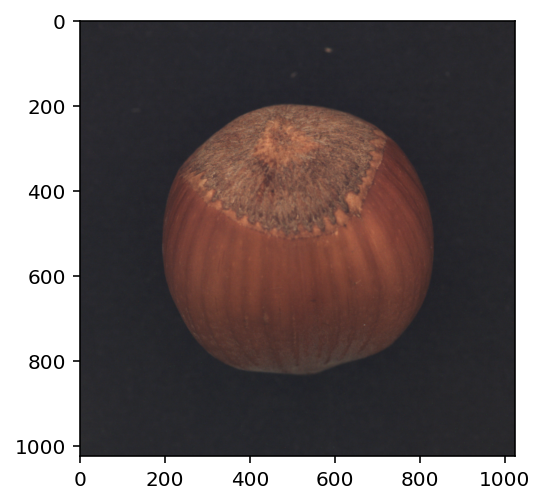

In [86]:
img_name = "./good/015.png"
attribute_list = ["normal", "abnormal", "good", "bad", "broken", "with scratch"]
get_clip_prob(img_name,attribute_list)
attribute_list = ["normal hazelnut", "abnormal hazelnut", "good hazelnut", "bad hazelnut", "broken hazelnut", "hazelnut with scratch"]
get_clip_prob(img_name,attribute_list)

In [85]:
good_data_dir = "./good/"
for filename in [filename for filename in os.listdir(good_data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    print(filename)
    img_name = good_data_dir+os.sep+filename
    #attribute_list = ["normal", "abnormal", "good", "bad", "broken", "scratch", "crack", "spoiled", "damaged", "wrecked"]
    #get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["normal hazelnut", "abnormal hazelnut", "spoiled food", "damaged food", "damaged hazelnut", "good hazelnut", "bad hazelnut", "broken hazelnut", "hazelnut with scratch", "hazelnut with crack"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["anormaly", "normal"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["broken object", "normal object"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["abnormal hazelnut", "normal hazelnut"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["broken hazelnut", "normal hazelnut"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["hazelnut with crack", "complete hazelnut"]
    get_clip_prob(img_name,attribute_list,vis=False)

021.png
### ./good//021.png
normal hazelnut:  0.4966
abnormal hazelnut:  0.118
spoiled food:  3e-07
damaged food:  3.33e-05
damaged hazelnut:  0.2576
good hazelnut:  0.002094
bad hazelnut:  0.000833
broken hazelnut:  0.01866
hazelnut with scratch:  0.005104
hazelnut with crack:  0.1009
### ./good//021.png
anormaly:  0.954
normal:  0.04602
### ./good//021.png
broken object:  0.002758
normal object:  0.997
### ./good//021.png
abnormal hazelnut:  0.1968
normal hazelnut:  0.803
### ./good//021.png
broken hazelnut:  0.03622
normal hazelnut:  0.964
### ./good//021.png
hazelnut with crack:  0.8843
complete hazelnut:  0.11597
022.png
### ./good//022.png
normal hazelnut:  0.2898
abnormal hazelnut:  0.1652
spoiled food:  1.13e-06
damaged food:  0.0001874
damaged hazelnut:  0.3723
good hazelnut:  0.00247
bad hazelnut:  0.000982
broken hazelnut:  0.02068
hazelnut with scratch:  0.00491
hazelnut with crack:  0.1436
### ./good//022.png
anormaly:  0.9473
normal:  0.0526
### ./good//022.png
broken obj

In [80]:
good_data_dir = "./scratch/"
for filename in [filename for filename in os.listdir(good_data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    print(filename)
    img_name = good_data_dir+os.sep+filename
    #attribute_list = ["normal", "abnormal", "good", "bad", "broken", "scratch", "crack"]
    #get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["normal hazelnut", "abnormal hazelnut", "spoiled food", "damaged food", "damaged hazelnut", "good hazelnut", "bad hazelnut", "broken hazelnut", "hazelnut with scratch", "hazelnut with crack"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["anormaly", "normal"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["anomaly object", "normal object"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["abnormal hazelnut", "normal hazelnut"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["broken hazelnut", "normal hazelnut"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["hazelnut with crack", "normal hazelnut"]
    get_clip_prob(img_name,attribute_list,vis=False)
    attribute_list = ["hazelnut with crack", "complete hazelnut"]
    get_clip_prob(img_name,attribute_list,vis=False)

001.png
### ./scratch//001.png
Label normal hazelnut probs: 0.2532
Label abnormal hazelnut probs: 0.0692
Label spoiled food probs: 5.2e-06
Label damaged food probs: 0.0003867
Label damaged hazelnut probs: 0.424
Label good hazelnut probs: 0.002947
Label bad hazelnut probs: 0.002813
Label broken hazelnut probs: 0.1635
Label hazelnut with scratch probs: 0.01363
Label hazelnut with crack probs: 0.0703
### ./scratch//001.png
Label anormaly probs: 0.769
Label normal probs: 0.231
### ./scratch//001.png
Label anomaly object probs: 0.37
Label normal object probs: 0.63
### ./scratch//001.png
Label abnormal hazelnut probs: 0.2173
Label normal hazelnut probs: 0.7827
### ./scratch//001.png
Label broken hazelnut probs: 0.3887
Label normal hazelnut probs: 0.6113
### ./scratch//001.png
Label hazelnut with crack probs: 0.2147
Label normal hazelnut probs: 0.785
### ./scratch//001.png
Label hazelnut with crack probs: 0.84
Label complete hazelnut probs: 0.1603
016.png
### ./scratch//016.png
Label normal h

In [52]:
!ls ./good




000.png  005.png  010.png  015.png  020.png  025.png  030.png  035.png
001.png  006.png  011.png  016.png  021.png  026.png  031.png  036.png
002.png  007.png  012.png  017.png  022.png  027.png  032.png  037.png
003.png  008.png  013.png  018.png  023.png  028.png  033.png  038.png
004.png  009.png  014.png  019.png  024.png  029.png  034.png  039.png


In [51]:
!unzip hazelnut2.zip 


Archive:  hazelnut2.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of hazelnut2.zip or
        hazelnut2.zip.zip, and cannot find hazelnut2.zip.ZIP, period.


In [8]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("007.png")).unsqueeze(0).to(device)
text = clip.tokenize(["normal", "abnormal", "anormaly"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.3242 0.0886 0.587 ]]


In [9]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("015.png")).unsqueeze(0).to(device)
text = clip.tokenize(["normal", "abnormal", "anormaly"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.11066 0.0327  0.8564 ]]


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [21]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [22]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [23]:
print(image_features.size())
print(text_features.size())

torch.Size([8, 768])
torch.Size([8, 768])


## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [24]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

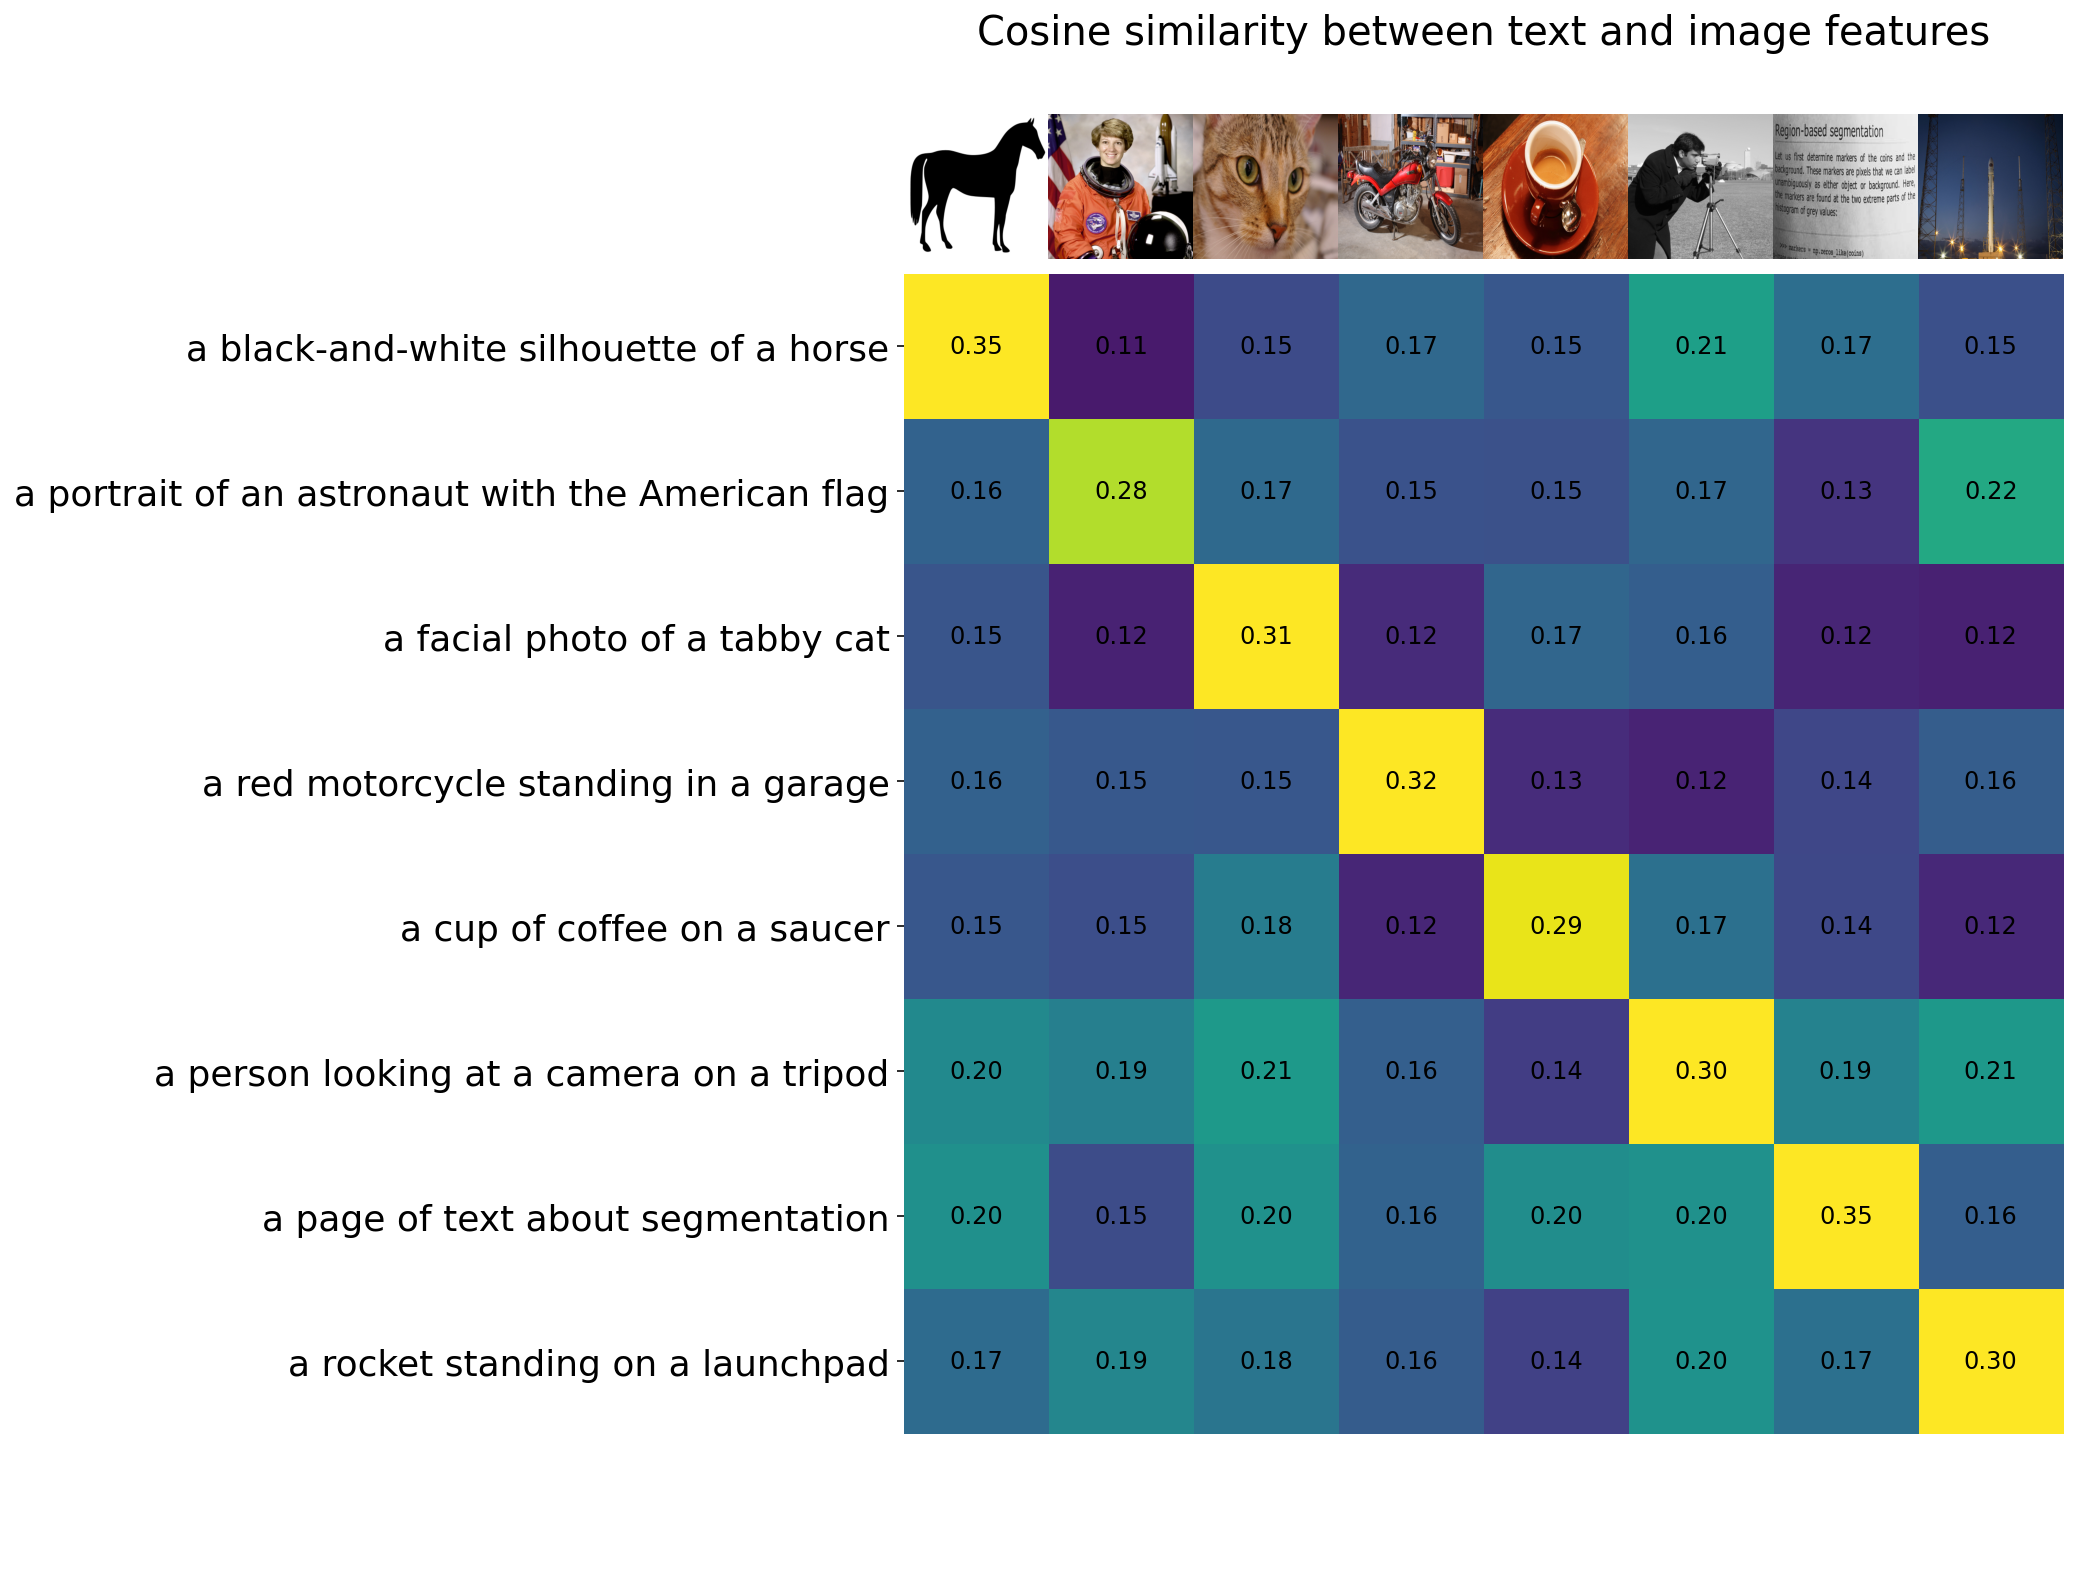

In [13]:
## vitB
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

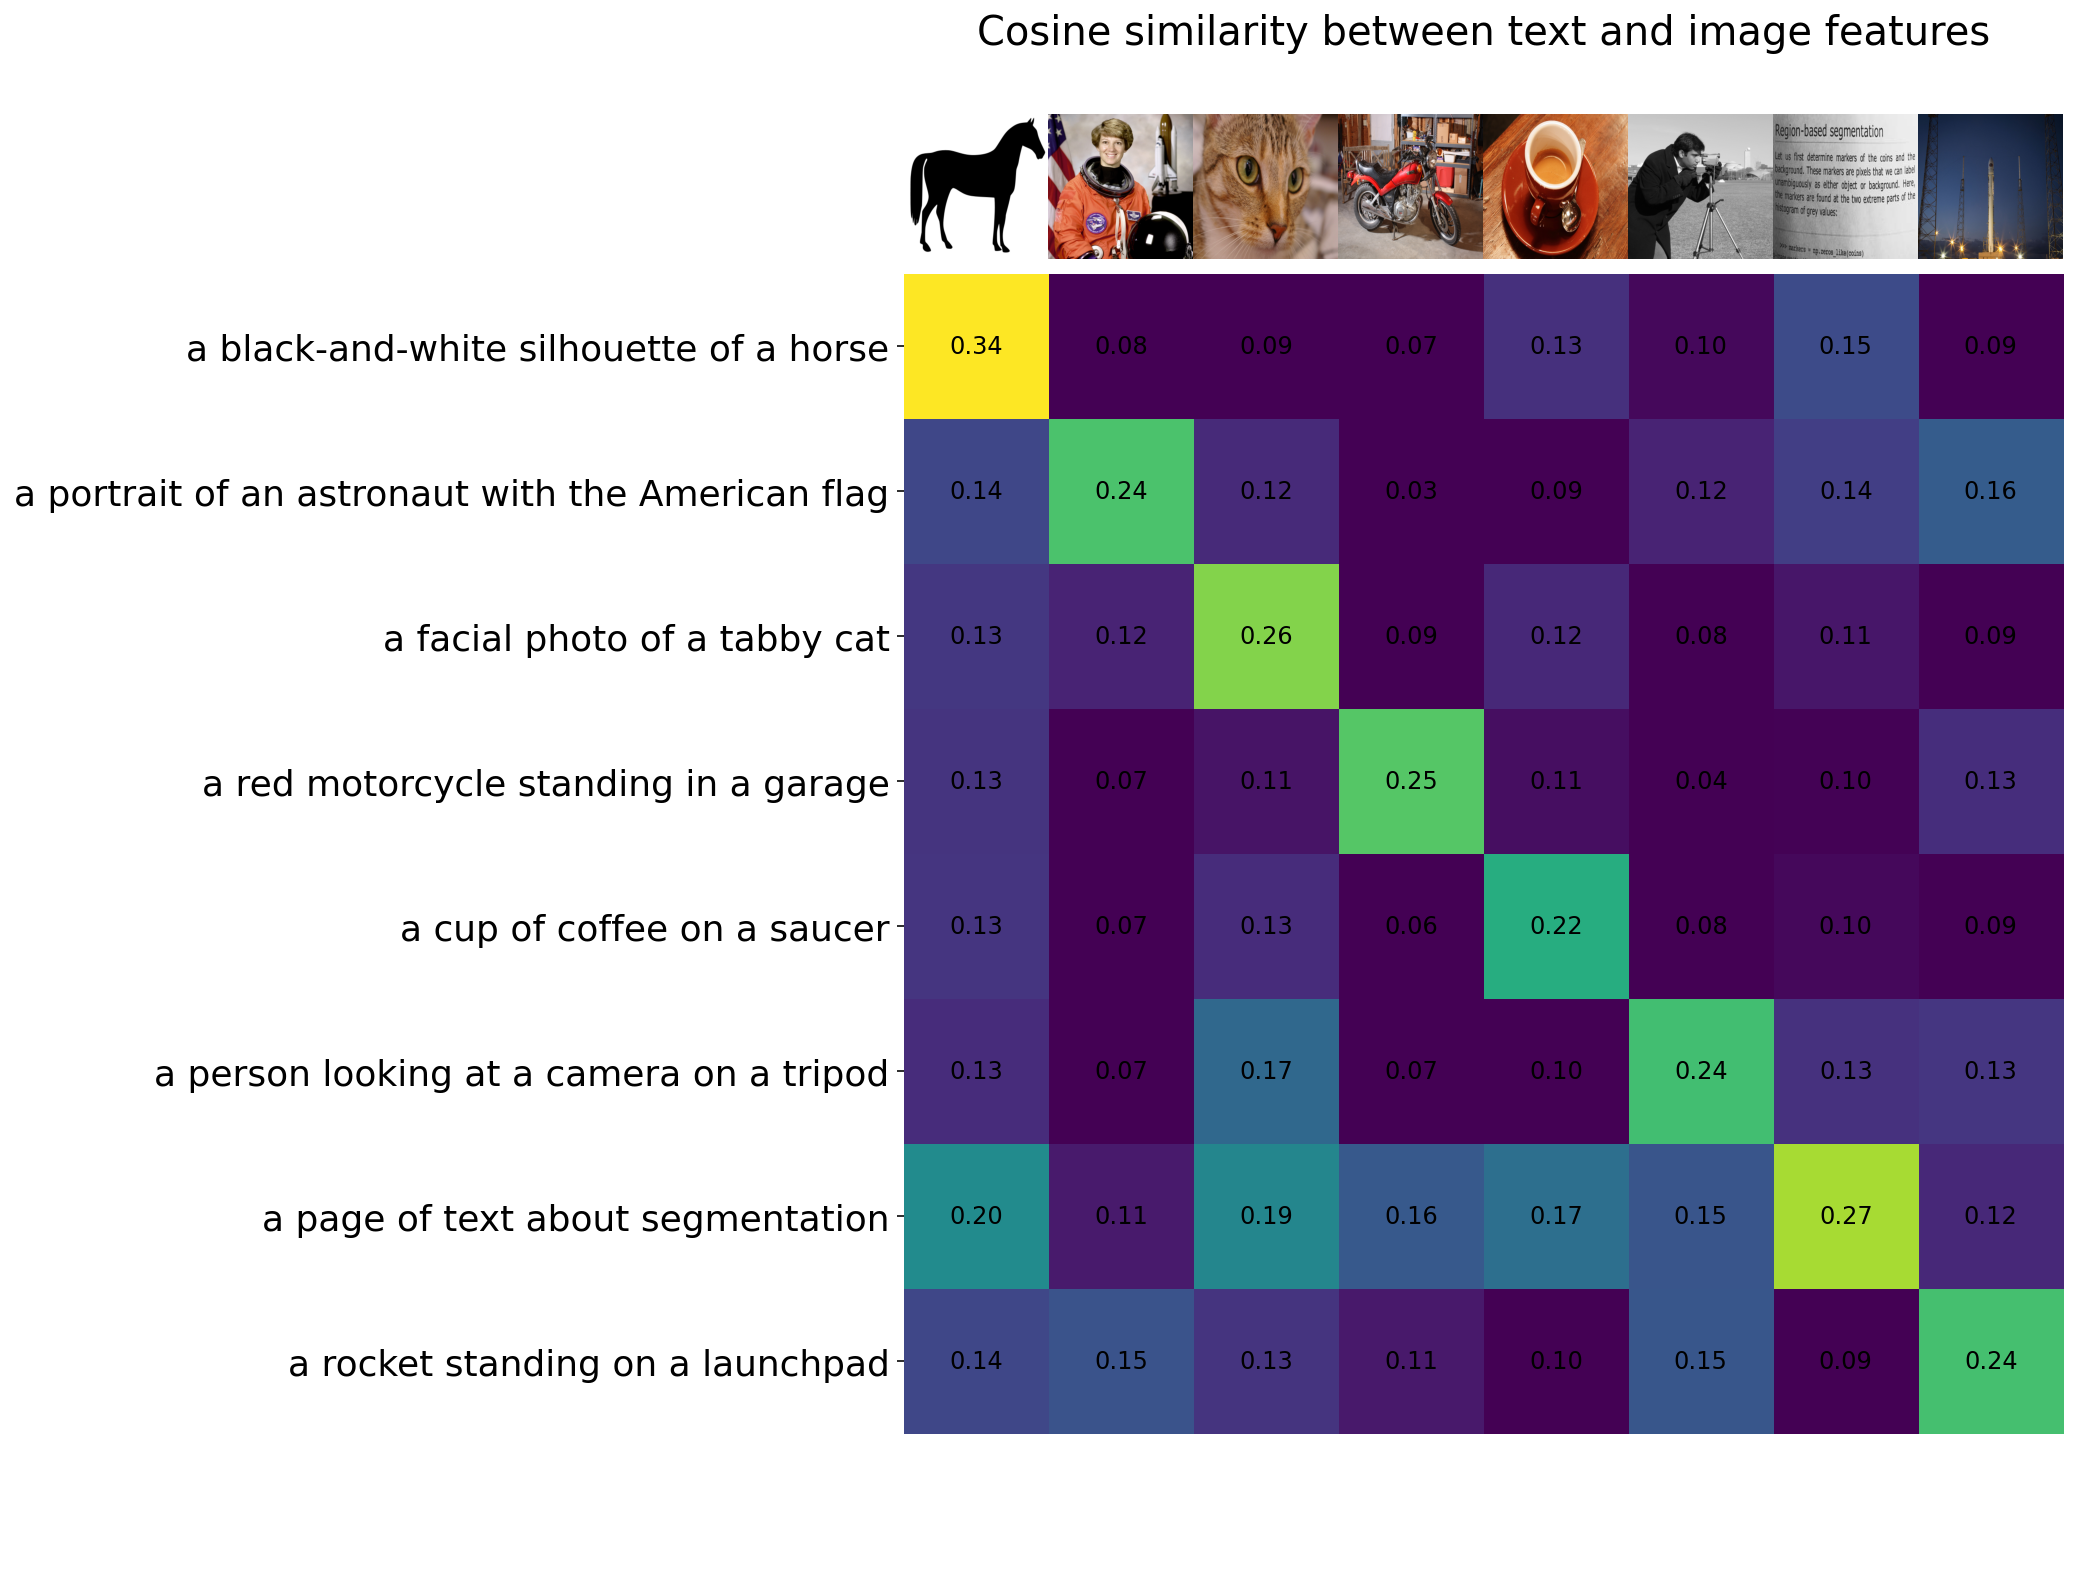

In [25]:
# Vit-L
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

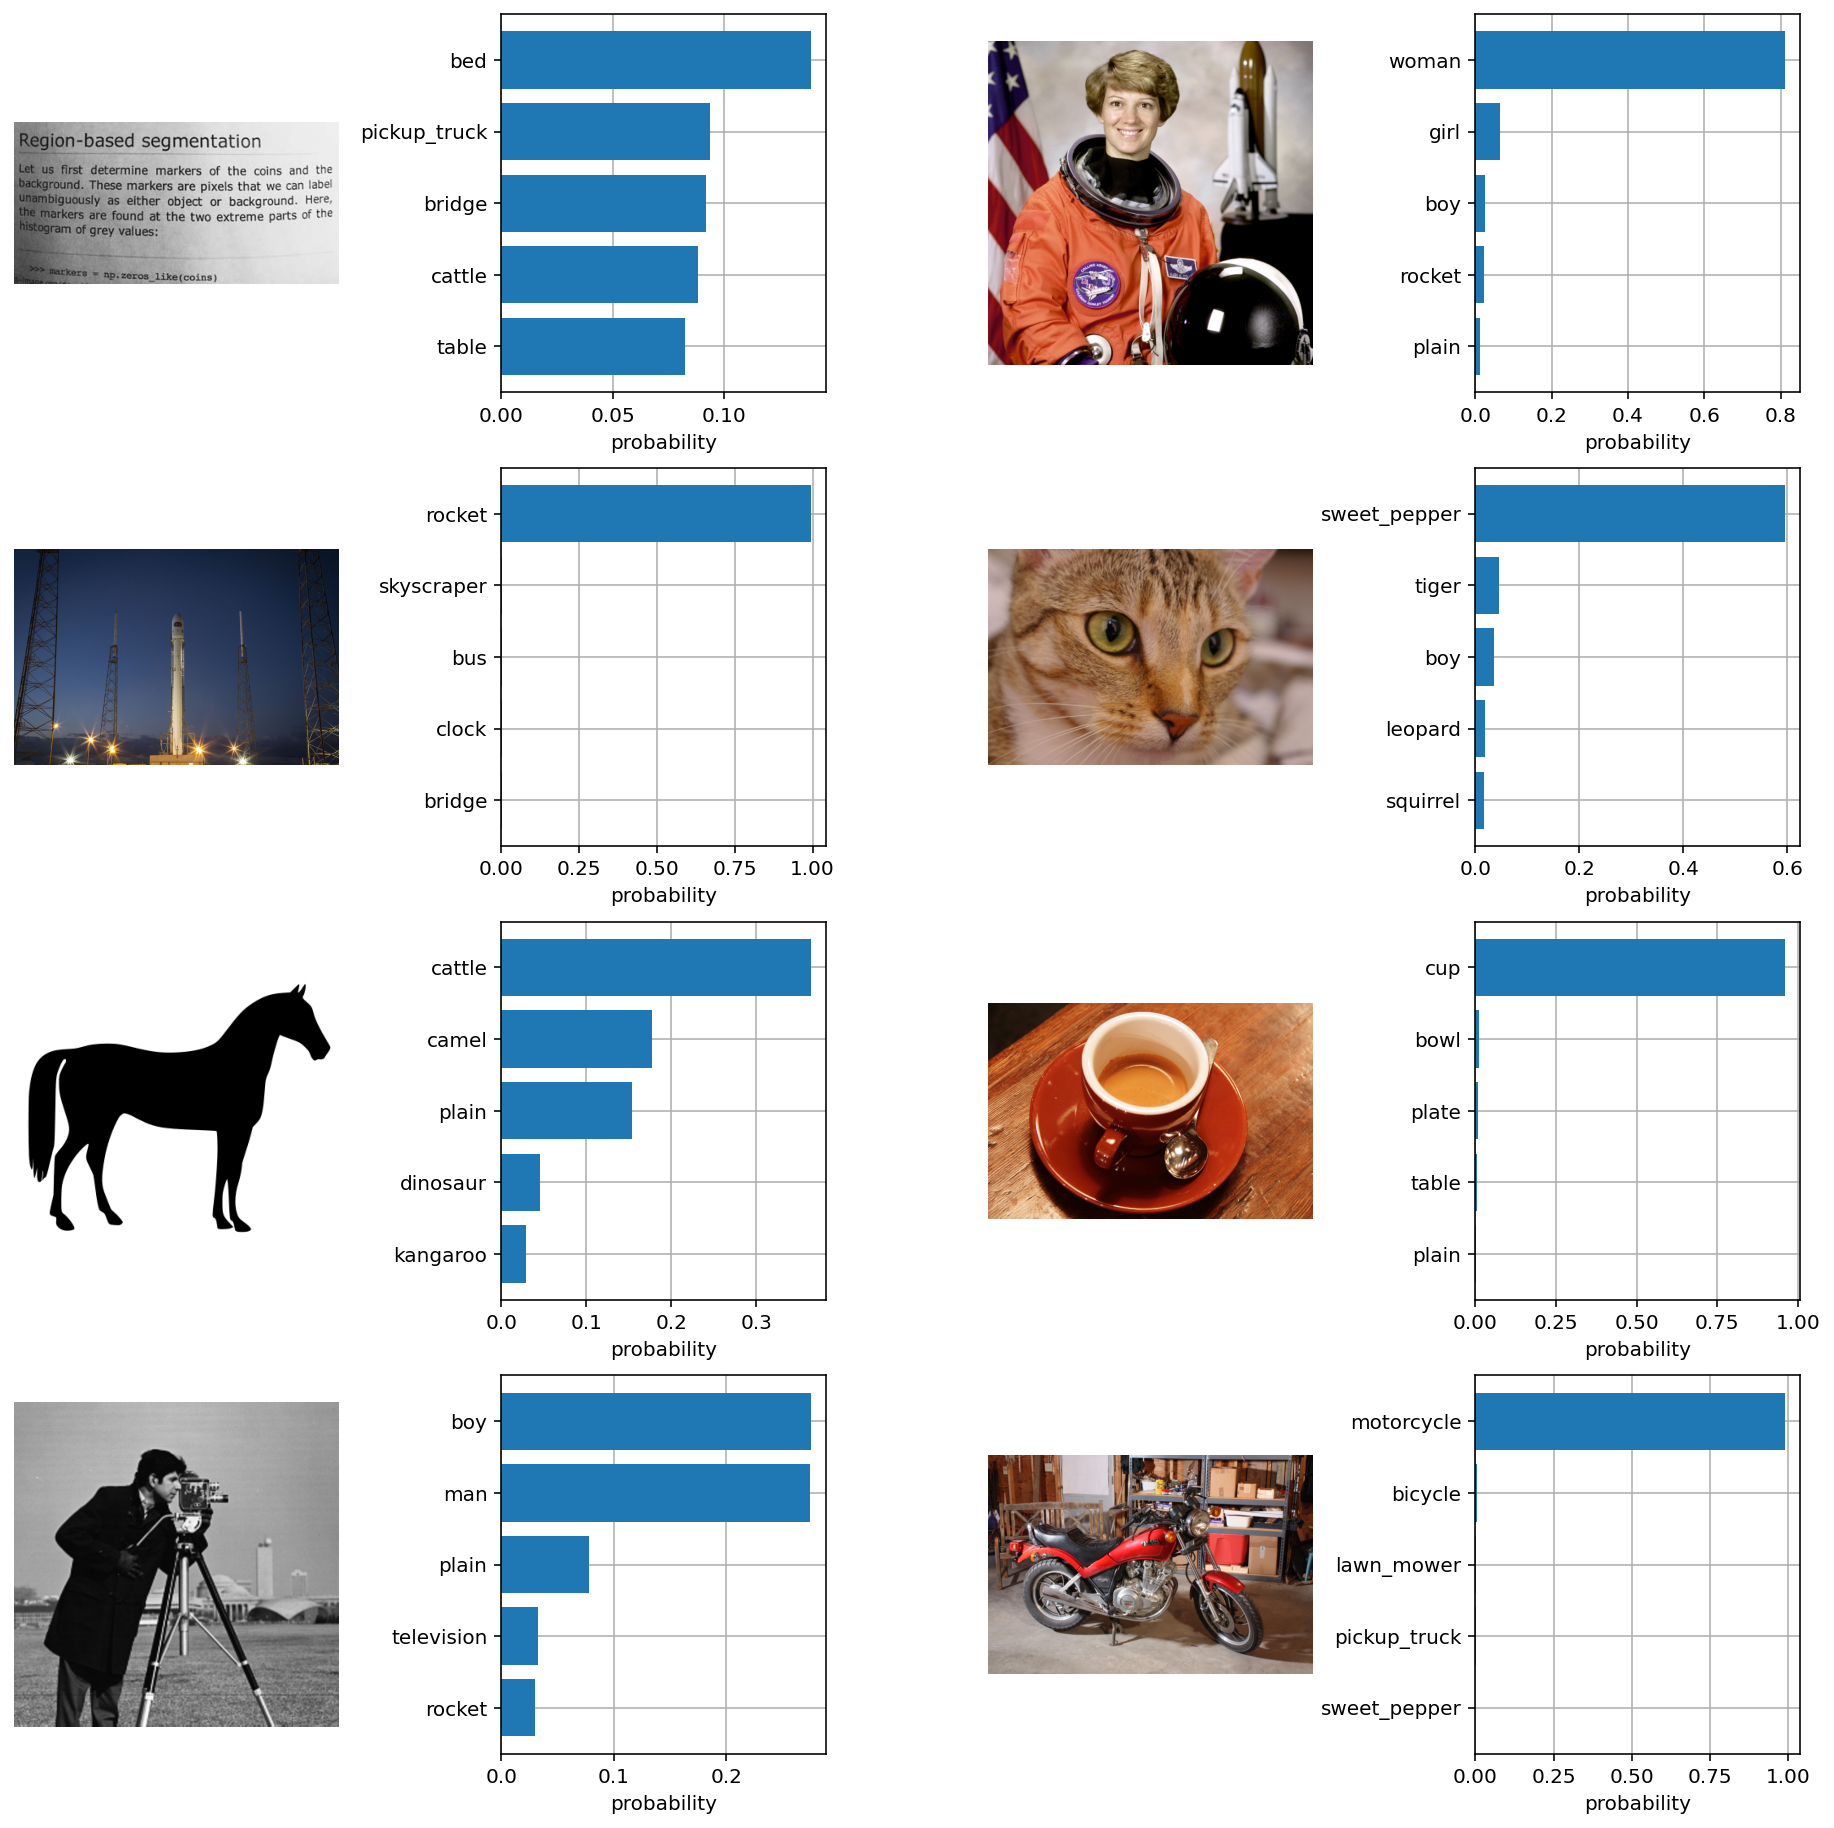

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()